### Registering cavity and spontaneous emissions 

We start with a non-hermitian Hamiltonian which we can write as
\begin{equation}
H = H_s + \frac{i\hbar}{2} \sum \limits_m C^\dagger_m C_m.
\end{equation}
Having the non-hermitian Hamiltonian we want to know the temporal evolution of our quantum state by quantum trajectory method, keeping a register of the number of spontaneous and cavity emissions.

In [176]:
using QuantumOptics
#Parameters
N_cutoff = 50 #dimension of our fock space
max_c = 100 #maximum number cavity emissions
g = 0.1 #atom-cavity mode coupling constant

#Bases
b_fock = FockBasis(N_cutoff)
b_spin = SpinBasis(1//2)

# Fundamental operators
a = destroy(b_fock)
at = create(b_fock)
n = number(b_fock)

sm = sigmam(b_spin)
sp = sigmap(b_spin)
sz = sigmaz(b_spin)
spsm = sp*sm

# Initial wavefunction
Ψ₀ = fockstate(b_fock, 0) ⊗ spindown(b_spin)

#Initial array where we register cavity and spontaneous emissions
veclossdec = zeros(max_c,2)

function mntwf(Ψ₀::QuantumOptics.states.Ket, Tfinal::Float64, Tinitial::Float64, n1::Int64, Ω::Float64, κ::Float64,γ::Float64)
    #We define the Hamiltonian within the our main function so we can freely change parameters
    
    #Hamiltonian hermitian
    Hint = 1im*g*(a⊗sp - at⊗sm) #interaction atom-cavity mode   
    Hlas = 1im*Ω*(a - at) #interaction laser-cavity mode

    #Hamiltonian non-hermitian
    Hnh1 = -1im*γ*0.5*sp*sm
    Hnh2 = -1im*κ*n
    
    H = Hint + Hlas⊗identityoperator(b_spin) + identityoperator(b_fock)⊗Hnh1 + Hnh2⊗identityoperator(b_spin)
    
    #We initialize our spontaneous and cavity emissions at 0
    num_dec = 0 
    num_loss = 0
    k = 1
    dt =(Tfinal-Tinitial)/n1
    time = [0:dt:dt;]
    
    #Initial arraya where we register cavity and spontaneous emissions, and expected values
    veclossdec = zeros(max_c,2)
    n_average = zeros(Float64, n1)
    spsm_average = zeros(Float64, n1)
    Ψ = Ψ₀
    for i in 1:n1
        tout, wf = timeevolution.schroedinger(time,Ψ,H); #we calculcate evolution of our state for an interval dt
        expectval = real(expect(n⊗identityoperator(b_spin), normalize(Ψ)))
        expectvals = real(expect(identityoperator(b_fock)⊗spsm, normalize(Ψ)))
        n_average[i] += expectval
        spsm_average[i] +=expectvals
        collapse_probability1 = (γ)*dt*expectvals
        collapse_probability2 = (2κ)*dt*expectval
        collapse_probability = collapse_probability1 + collapse_probability2
        collapse_probabilityr1 = collapse_probability1/collapse_probability
        if collapse_probability > rand() #we check if the is a quantum jump
                if collapse_probabilityr1 > rand() #we see if the is a spontaneuos emission
                    Ψ = (sqrt(γ)*identityoperator(b_fock) ⊗ sm*Ψ)/norm(sqrt(γ)*identityoperator(b_fock) ⊗ sm*Ψ)
                    num_dec = num_dec + 1
                else #else the is a cavity emission
                    Ψ = ((sqrt(2*κ)*a ⊗ identityoperator(b_spin))*wf[2])/norm(sqrt(2*κ)*a ⊗ identityoperator(b_spin)*wf[2])
                    num_loss = num_loss + 1
                    #we register cavity emissions vs. spontaneuos emissions
                    veclossdec[k,1] = num_loss
                    veclossdec[k,2] = num_dec
                    k = k + 1
                    if num_loss == max_c #we cut when we reach maximum number of cavity emissions
                        break
                    else
                    end
                end
        else
            Ψ = wf[2]
        end
        time = [(i*dt):dt:(i*dt)+dt;]
    end
    return  veclossdec, time, n_average, spsm_average
end

a,b,c,d = mntwf(Ψ₀,1000.0,0.0,10000,0.12,0.1,1.0);

We can graph the expected values of our quantum trajectory in order to gain insights about the dynamics of our system

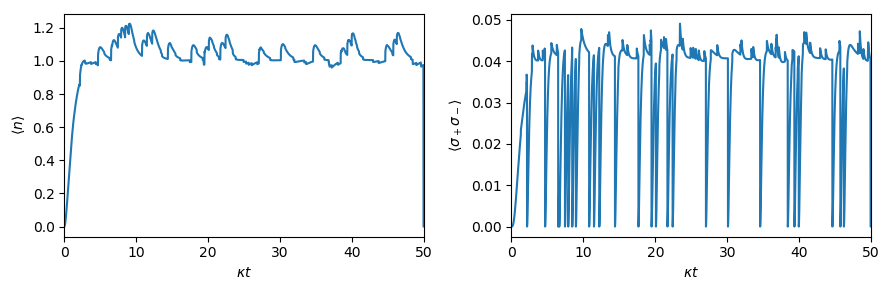

In [177]:
using PyPlot
t = [0:0.1:999.9;]

figure(figsize=(9,3))
subplot(1,2,1)
plot(t*0.1,c)
xlim(0,50)
xlabel(L"\kappa t")
ylabel(L"\langle n \rangle")
subplot(1,2,2)
plot(t*0.1,d)
xlim(0,50)
xlabel(L"\kappa t")
ylabel(L"\langle \sigma_+ \sigma_- \rangle")
tight_layout()

### Creating Probability Distributions 
Having created arrays that relate the number of cavity emissions with spontaneous emissions, the next step is to use this data to create probability distributions.

In [186]:
using QuantumOptics
##Parameters
N_cutoff = 50 #dimension of our fock space
max_c = 100 #maximum number cavity emissions
g = 0.1 #atom-cavity mode coupling constant
#
#Bases
b_fock = FockBasis(N_cutoff)
b_spin = SpinBasis(1//2)
#
## Fundamental operators
a = destroy(b_fock)
at = create(b_fock)
n = number(b_fock)

sm = sigmam(b_spin)
sp = sigmap(b_spin)
sz = sigmaz(b_spin)
spsm = sp*sm


function counter(num::Int64, num1::Float64, num2::Float64, num3::Float64)
    matrix = zeros(200,100) #we define a matrix where we storage number of spontaneous emissions (rows) for each cavity emission
    for j in 1:num #num is the number we are going to repeat the quantum trajectory in order to get prob. dist.
        veclossdec1, atime1, n_av,sz_av = mntwf(Ψ₀,1000.0,0.0,10000,num1,num2,num3)
        for i in 1:100 #once we do the trajectory, we go through the rows of spontaneous emissions
            a = veclossdec1[i,2] #we take the value of the spontaneous emission for each cavity emission
            int = trunc(Int, a) + 1 #we turn it into an int
            matrix[int,i] +=  1 #we sum 1 into int,i; where int, would be the row equal to the number of spontaneous emission and i, is the number of the column of the cavity emission
        end   
    end
    #writedlm("matrix$num$num1$num2$num3.txt", matrix) In the case of using cluster we storage the data on a text file
    return matrix #we return matrix which is going to gives the register
end

mat_prob = counter(10000,0.12,0.1,1.0); #here we try 10000 quantum trajectories, for better results one should do more; in the thesis it was done with 100k
mat_prob;

### Graphing our probability distributions
Lastly we extract the data from our matrix and graph our probability distributions

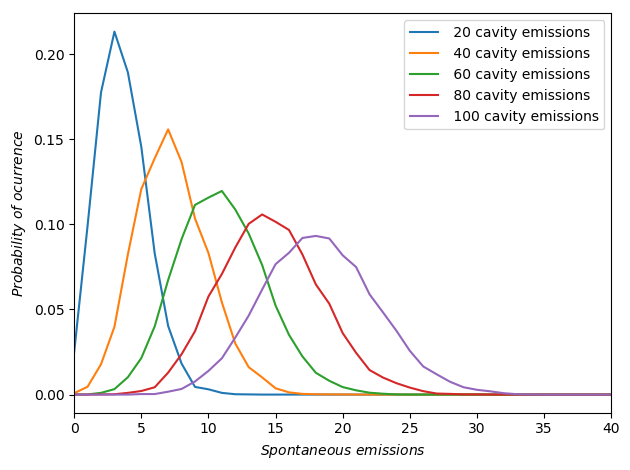

In [187]:
#since we use only 10000 times, the probability distributions are not as good; in the thesis we did for 100,000 quantum trajectories
using PyPlot

bk = mat_prob*1/10000
for j in 20:20:100
    i = [1:1:51;]
    plot(bk[1:51,j], label =" $j cavity emissions")
end
xlim(0,40)
#ylim(0,.35)
xlabel(L"Spontaneous \ emissions")
ylabel(L"Probability \ of \ ocurrence");
#title(L"Distribución \ de \ probabilidad \ con \ \langle n \rangle = 1, \ \kappa = 0.2")
legend()
tight_layout()